In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf

from model_tuner import ModelTuner


In [2]:
df = pd.read_csv(os.path.join('data', 'features.csv'))
df.head()


,content,wording,keyword_overlap,summary_lengths,vocab_size,Average_sentence_lengths_ratio,objectivity,Semantic_similarity,flesch_reading_ease,spell_errors
0,0.205683,0.380538,4,43,36,1.075000,0.835,0.854158,1.136179,2
1,-0.548304,0.506755,5,25,19,1.785714,0.947,0.889245,1.319293,0
2,3.128928,4.231226,19,177,119,2.011364,0.816,0.877361,0.906089,3
3,-0.210614,-0.471415,3,18,16,1.227273,1.000,0.706003,0.944525,4
4,3.272894,3.219757,12,151,101,1.078571,0.898,0.866760,1.150467,11


In [3]:
X = df.iloc[:, 2:].values
y = df.iloc[:, :2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5732, 8), (1433, 8), (5732, 2), (1433, 2))

In [4]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)


In [5]:
def get_model(input_shape, hidden_layers, activation, optimizer, lr, loss):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for hidden_layer in hidden_layers:
        model.add(Dense(hidden_layer, activation=activation))
    model.add(Dense(2))
    if isinstance(optimizer, str):
        opt = optimizer
    else:
        opt = optimizer(learning_rate=lr)
    model.compile(optimizer=opt, loss=loss)
    return model

In [6]:
def mcrmse(y_true, y_pred):
  colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
  return tf.reduce_mean(tf.sqrt(colwise_mse))

In [7]:
params = {
    'hidden_layers': [(16,), (32,), (64,), (16,  8), (32, 16, 8), (64, 32, 16, 8)],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'optimizer': [Adam, SGD],
    'lr': [0.05, 0.03, 0.01, 0.008, 0.005],
    'loss': [mcrmse]
}

tuner = ModelTuner(get_model, params, 5, 1)
tuner.fit(X_train_scale, y_train, 100)


Experiment 1
{'hidden_layers': (16,), 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'lr': 0.05, 'loss': <function mcrmse at 0x0000022D54F68B80>}
Fold 0 loss = 0.5580374002456665
Fold 1 loss = 0.5450677871704102
Fold 2 loss = 0.5211374163627625
Fold 3 loss = 0.514358401298523
Fold 4 loss = 0.5552001595497131

Mean loss =  0.5388 STD =  0.0178

Experiment 2
{'hidden_layers': (16,), 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'lr': 0.03, 'loss': <function mcrmse at 0x0000022D54F68B80>}
Fold 0 loss = 0.5479015111923218
Fold 1 loss = 0.533720076084137
Fold 2 loss = 0.5242761373519897
Fold 3 loss = 0.5136750936508179
Fold 4 loss = 0.5294557213783264

Mean loss =  0.5298 STD =  0.0113

Experiment 3
{'hidden_layers': (16,), 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'lr': 0.01, 'loss': <function mcrmse at 0x0000022D54F68B80>}
Fold 0 loss = 0.5203860998153687
Fold 1 loss = 0.519966185092926
Fold 2

In [35]:
tuner.best_loss_

0.5050681531429291

In [36]:
best_model = get_model(X_train_scale.shape[1:], **tuner.best_params_)
history = best_model.fit(X_train_scale, 
                         y_train,
                         validation_data=[X_test_scale, y_test],
                         epochs=100)



Epoch 1/100
180/180 [==============================] - 1s 2ms/step - loss: 0.6686 - val_loss: 0.5776
Epoch 2/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5653 - val_loss: 0.5568
Epoch 3/100
180/180 [==============================] - 0s 1ms/step - loss: 0.5527 - val_loss: 0.5516
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 0.5464 - val_loss: 0.5461
Epoch 5/100
180/180 [==============================] - 0s 1ms/step - loss: 0.5378 - val_loss: 0.5531
Epoch 6/100
180/180 [==============================] - 0s 1ms/step - loss: 0.5378 - val_loss: 0.5444
Epoch 7/100
180/180 [==============================] - 0s 1ms/step - loss: 0.5341 - val_loss: 0.5370
Epoch 8/100
180/180 [==============================] - 0s 1ms/step - loss: 0.5314 - val_loss: 0.5400
Epoch 9/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5283 - val_loss: 0.5403
Epoch 10/100
180/180 [==============================] - 0s 2ms/step - loss: 0.5279 - val_lo

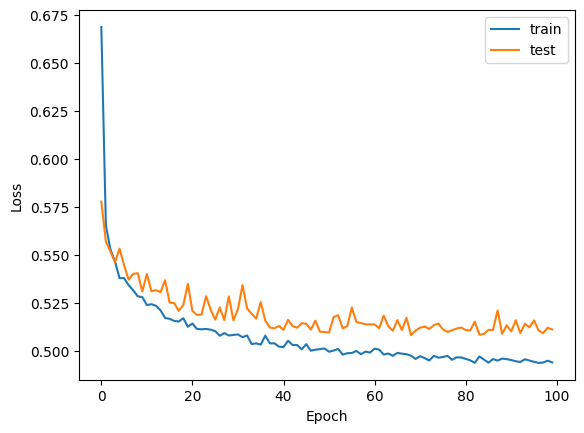

In [37]:
sns.lineplot(x=range(100), y=history.history['loss'], label='train')
sns.lineplot(x=range(100), y=history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [38]:
y_pred = best_model.predict(X_test_scale)
score = mcrmse(y_test, y_pred)
print(f'MCMRSE score: {score: .4f}')

45/45 [==============================] - 0s 931us/step
MCMRSE score:  0.5110
